### Info extraction for each data collection trial

In [1]:
import os
import pandas as pd
from datetime import datetime, timedelta
import re

def extract_time(text):
    # Adjust the regex to match the full timestamp format
    match = re.search(r'\- (.*)', text)
    if match:
        return datetime.strptime(match.group(1), '%a %b %d %H:%M:%S %Y')
    else:
        return None

def trial_info_read(csv_file_path):

    df = pd.read_csv(csv_file_path, usecols=[0], dtype={0: str}, header=None)

    # Drop all rows where the first column is NaN
    df = df.dropna(subset=[0])
    df = df.dropna(how='all')

    # Extract capture start time
    capture_start_cell = df.loc[df[0].str.contains("Capture start time", na=False)].values[0]
    capture_start_time = extract_time(capture_start_cell[0])

    # Extract capture end time
    capture_end_cell = df.loc[df[0].str.contains("Capture end time", na=False)].values[0]
    capture_end_time = extract_time(capture_end_cell[0])

    # Extract duration
    duration_cell = df.loc[df[0].str.contains("Duration", na=False)].values[0]
    duration = int(re.search(r'\d+', duration_cell[0]).group())

    print(f"Capture Start Time: {capture_start_time}")
    print(f"Capture End Time: {capture_end_time}")
    print(f"Duration: {duration}")


    # Read only the third column (index 2) and skip rows with NaN in this column
    df2 = pd.read_csv(csv_file_path, usecols=[1],skip_blank_lines=False)
    df2_numeric = pd.to_numeric(df2.iloc[:, 0], errors='coerce')
    bin_file_count = df2_numeric.notna().sum()
    bin_file_count=int(bin_file_count)
    print(f"Number of data bin files: {bin_file_count}")

    return capture_start_time,capture_end_time,duration,bin_file_count


#example usage
csv_file_path = '../2024-01-11/trial1/adc_data_2024-01-11_14-29-43_Raw_LogFile.csv'
capture_start,capture_end,total_duration,bin_file_count=trial_info_read(csv_file_path)


Capture Start Time: 2024-01-11 14:29:53
Capture End Time: 2024-01-11 14:52:32
Duration: 1359
Number of data bin files: 13


### Generate csv file to record data bin info

In [2]:
def get_file_size(file_path):
    """ Returns the file size in bytes. """
    if os.path.exists(file_path):
        return os.path.getsize(file_path)
    else:
        raise FileNotFoundError("File not found")


bin_file_directory = '../2024-01-11/trial1'
# Dictionary to store the file sizes
file_sizes = {}
total_data_points = 0

for file_name in os.listdir(bin_file_directory):
    if file_name.endswith('.bin'):
        file_path = os.path.join(bin_file_directory, file_name)
        file_size = os.path.getsize(file_path)
        # Assuming each sample includes both real and imaginary parts, each 16 bits:
        data_points = file_size // (2 * 2 * 4)  # Calculate number of complex samples (16-bit real + 16-bit imaginary) for 4 Rx
        file_sizes[file_name] = {'file_size': file_size, 'data_points': data_points}
        total_data_points += data_points

# Initialize a dictionary to hold the start and end times for each bin file
bin_files_time_info = {}

# Calculate the start and end times based on the proportion of data points
previous_end_time = capture_start

for file_name, info in file_sizes.items():
    data_points = info['data_points']
    file_duration = (data_points / total_data_points) * total_duration
    start_time = previous_end_time
    end_time = start_time + timedelta(seconds=file_duration)
    duration = end_time - start_time  # Calculate duration for each file
    file_name=str(os.path.join(bin_file_directory,file_name))
    bin_files_time_info[file_name] = {
        'start_time': start_time.strftime('%Y-%m-%d %H:%M:%S'),
        'end_time': end_time.strftime('%Y-%m-%d %H:%M:%S'),
        'duration_seconds': duration.total_seconds(),
        'data_points': data_points
    }
    previous_end_time = end_time  # update the previous end time to the current end time

# Convert the time information dictionary to a DataFrame
time_info_df = pd.DataFrame.from_dict(bin_files_time_info, orient='index')

# Save the bin files time information to a new CSV file
output_path='../2024-01-11/trial1/bin_files_time_info.csv'
time_info_df.to_csv(output_path)
print(output_path)


../2024-01-11/trial1/bin_files_time_info.csv


### Radar data segment waveform extraction

**Output data type**
1. Raw data
2. IQ data
3. Unwrapped data
4. Original multi-range bin data


**Target localization option**
1. Peak tracking (3D-FFT)
2. Peak tracking (2D-FFT)
3. One-time detection (locate target only using 1st frame the fix range bin)
4. ...

In [3]:
import numpy as np
import os
import pandas as pd
import scipy
from datetime import datetime
from mmwave.dsp.cfar import ca
from mmwave.dsp.doppler_processing import doppler_processing,doppler_resolution
from mmwave.dsp.range_processing import range_processing,range_resolution
from mmwave.dsp.noise_removal import prune_to_peaks,range_based_pruning,peak_grouping_along_doppler
import matplotlib.pyplot as plt


class RadarDataProcessor:
    def __init__(self, radar_config, csv_path):
        self.config=radar_config    
        self.csv_path = csv_path
        self.bin_file_info = self.read_csv_info(csv_path)
        self.rangeMin=0.2 # m
        self.rangeMax=1.6 # m

    @staticmethod
    def readDCA1000(fileName):
        if not os.path.isfile(fileName):
            raise ValueError('File not found')
        numADCBits = 16 
        numLanes = 4     
        isReal = False 
        with open(fileName, 'rb') as fid:
            adcData = np.fromfile(fid, dtype=np.int16)
            if numADCBits != 16:
                l_max = 2**(numADCBits-1)-1
                adcData[adcData>l_max]=2**numADCBits
        if isReal:
            adcData = np.reshape(adcData, (numLanes, -1))
        else:
            adcData = np.reshape(adcData, (numLanes*2, -1))
            adcData = adcData[:numLanes, :]+1j*adcData[numLanes:, :]
        return adcData
        
    def read_csv_info(self, csv_path):
        # Read and process the CSV file to get metadata for each bin file
        df = pd.read_csv(csv_path)
        df['start_time'] = pd.to_datetime(df['start_time'])
        df['end_time'] = pd.to_datetime(df['end_time'])
        return df
    
    def find_relevant_bin(self, start_datetime, end_datetime):
        # Filter DataFrame to find the bin file that covers the requested time span
        relevant_bins = self.bin_file_info[
            (self.bin_file_info['start_time'] <= start_datetime) & 
            (self.bin_file_info['end_time'] >= end_datetime)]
        return relevant_bins
    
    def extract_data_by_timestamp(self, start_datetime, end_datetime):
        relevant_bin = self.find_relevant_bin(start_datetime, end_datetime)
        if relevant_bin.empty:
            raise ValueError("No bin file covers the provided time span")
        
        # Read the bin data from the relevant file
        bin_data = self.readDCA1000(relevant_bin.iloc[0,0])

        # Calculate indexes based on data points and timestamps
        total_seconds = (end_datetime - start_datetime).total_seconds()
        start_idx = int(((start_datetime - relevant_bin.iloc[0]['start_time']).total_seconds() / total_seconds) * relevant_bin.iloc[0]['data_points'])
        end_idx = int(((end_datetime - relevant_bin.iloc[0]['start_time']).total_seconds() / total_seconds) * relevant_bin.iloc[0]['data_points'])
        
        return bin_data[:, start_idx:end_idx]
    
    
    def target_detection_by_frame(self,rawDataCube, method='peak',rx=0):
        
        range_re,bandwidth=range_resolution(self.config['Nadc'], self.config['sample_rate'], self.config['slope'])
        
        # doppler_re=doppler_resolution(bandwidth, self.config['f0'], self.config['ramp_end_time'], 
        #                               self.config['idle_time'], self.config['Nchirp'], self.config['Tx'])
        
        rawDataCube=np.reshape(rawDataCube,(self.config['Tx']*self.config['Rx'],self.config['Nadc'],self.config['Nchirp'])) #(x,y,z)
        rawDataCube=np.transpose(rawDataCube, (2, 0, 1))  # (z, x, y)(128,4,256)
        range_FFT=range_processing(rawDataCube)
        dopplermap, aoa_input=doppler_processing(range_FFT,clutter_removal_enabled=True,num_tx_antennas=1,accumulate=False)        

        if method == 'CFAR':
            detected_indices=ca(dopplermap, l_bound=10, guard_len=10, noise_len=8)
            target_candidates=np.abs(dopplermap)*detected_indices
            # ignore data out of range

            if self.rangeMin is not None and self.rangeMax is not None:
                target_candidates[:int(self.rangeMin/range_re),:] = 0  
                target_candidates[int(self.rangeMax/range_re):,:] = 0 
            peak = np.max(target_candidates)
            indices = np.where(dopplermap== peak)
            row=indices[0] 
            col=indices[1]

        elif method == 'peak':
            dopplermap=np.abs(dopplermap)
            if self.rangeMin is not None and self.rangeMax is not None:
                dopplermap[:int(self.rangeMin/range_re),:] = 0  
                dopplermap[int(self.rangeMax/range_re):,:] = 0  
            peak = np.max(dopplermap)
            indices = np.where(dopplermap== peak)
            row=indices[0] 
            col=indices[1]
        else:
            raise ValueError("Unsupported method")
        idata=rawDataCube[col,rx,row].real
        qdata=rawDataCube[col,rx,row].imag
        return idata, qdata, [col, row]
        
    
    def target_detection(self, raw_data, method='peak', tracking=False):
        """
        Apply target detection algorithms to radar data.
        
        Args:
        iq_data (numpy.ndarray): The IQ data array from radar.
        method (str): The detection method to use ('CFAR', 'peak').
        
        Returns:
        targets (numpy.ndarray): Detected targets' information.
        """
        # Trimming the data in order to keep only the complete frame
        Nframe = int(np.floor(raw_data.shape[1] / (self.config['Nadc'] * self.config['Nchirp'])))
        NDataPoints = Nframe * self.config['Nadc'] * self.config['Nchirp']
        trimmed_rawData = raw_data[:, :NDataPoints]
        # rawData_reshaped = np.reshape(trimmed_rawData, (self.config['Rx']*self.config['Tx'], self.config['Nadc'],-1))
        Idata=np.array([])
        Qdata=np.array([])
        if tracking:
            for i in range(0,Nframe):
                cdata = trimmed_rawData[:,  i*self.config['Nchirp']*self.config['Nadc']:(i+1)*self.config['Nchirp']*self.config['Nadc']].flatten()
                i_data,q_data,_=self.target_detection_by_frame(cdata,method)
                Idata=np.append(Idata,i_data)
                Qdata=np.append(Qdata,q_data)
        else:
            cdata = trimmed_rawData[:,  :self.config['Nchirp']*self.config['Nadc']].flatten() #only 1st frame
            i_data,q_data,idx=self.target_detection_by_frame(cdata,method)
            Idata=np.append(Idata,i_data)
            Qdata=np.append(Qdata,q_data)
            for i in range(1,Nframe): 
                cdata = trimmed_rawData[:, i*self.config['Nchirp']*self.config['Nadc']:(i+1)*self.config['Nchirp']*self.config['Nadc']].flatten()
                rawDataCube=np.reshape(cdata,(self.config['Tx']*self.config['Rx'],self.config['Nadc'],self.config['Nchirp'])) #(x,y,z)
                rawDataCube=np.transpose(rawDataCube, (2, 0, 1))  # (z, x, y)(128,4,256)
                Idata=np.append(Idata,rawDataCube[idx[0],0,idx[1]].real)
                Qdata=np.append(Qdata,rawDataCube[idx[0],0,idx[1]].imag)
        
        return Idata,Qdata


# Example usage:
Args = {
    'f0':77,                    # Hz
    'ADCStarttime': 6,    # us
    'slope': 29.982,            # MHz/us
    'idle_time': 100,       # us
    'ramp_end_time': 60,    # us
    'Nadc': 256,             # samples per chirp
    'sample_rate': 10000,    # samples per second (ksps)
    'Rx': 4,                      # Number of RX channels
    'Tx': 1,                      # Number of TX channels
    'Nchirp': 128,                # Number of chirps per frame
    'Period': 40            # ms
}# All transferred to s
output_path='../2024-01-11/trial1/bin_files_time_info.csv'
processor = RadarDataProcessor(Args,output_path)
start_time = datetime(2024, 1, 11, 14, 31, 55)
end_time = datetime(2024, 1, 11, 14, 32, 15)
radar_rawdata = processor.extract_data_by_timestamp(start_time, end_time)
print(radar_rawdata.shape)
Idata,Qdata=processor.target_detection(raw_data=radar_rawdata)
plt.subplot(211)
plt.plot(Idata)
plt.subplot(212)
plt.plot(Qdata)
plt.show()

In [ ]:

trimmed_rawData = radar_rawdata[:, :256*128]
# rawData_reshaped = np.reshape(trimmed_rawData, (self.config['Rx']*self.config['Tx'], self.config['Nadc'],-1))
cdata = trimmed_rawData.flatten()
rawDataCube=np.reshape(rawDataCube,(4,256,128)) #(x,y,z)
rawDataCube=np.transpose(rawDataCube, (2, 0, 1))  # (z, x, y)(128,4,256)
range_FFT=range_processing(rawDataCube)
dopplermap, aoa_input=doppler_processing(range_FFT,clutter_removal_enabled=True,num_tx_antennas=1,accumulate=False)      

[[77.94025549  0.          0.         ...  0.          0.
   0.        ]
 [66.24425318  0.          0.         ...  0.          0.
   0.        ]
 [67.21865026  0.          0.         ...  0.          0.
   0.        ]
 ...
 [63.65313156  0.          0.         ...  0.          0.
   0.        ]
 [63.99788181  0.          0.         ...  0.          0.
   0.        ]
 [64.49214701  0.          0.         ...  0.          0.
   0.        ]]


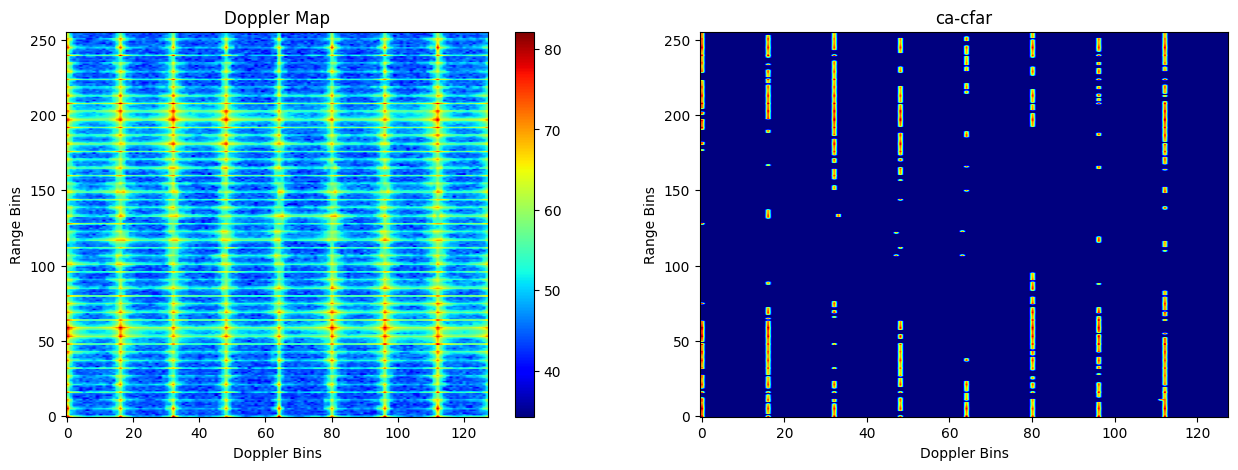

In [11]:
import matplotlib.pyplot as plt

# Assuming dopplermap is a 2D numpy array with shape (range_bins, doppler_bins)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(np.abs(dopplermap), aspect='auto', cmap='jet', origin='lower')
plt.colorbar()
plt.title('Doppler Map')
plt.xlabel('Doppler Bins')
plt.ylabel('Range Bins')

plt.subplot(122)
detected_indices=ca(dopplermap, l_bound=10, guard_len=10, noise_len=8)
print(np.abs(dopplermap)*detected_indices)
plt.imshow(np.abs(dopplermap)*detected_indices, aspect='auto', cmap='jet', origin='lower')
plt.title('ca-cfar')
plt.xlabel('Doppler Bins')
plt.ylabel('Range Bins')
plt.show()

In [7]:

from mmwave.dsp.doppler_processing import doppler_resolution


range_re,bandwidth=range_resolution(Args['Nadc'], dig_out_sample_rate=10000, freq_slope_const=29.982)
doppler_re=doppler_resolution(bandwidth, start_freq_const=77, ramp_end_time=60, idle_time_const=100, num_loops_per_frame=128,
                       num_tx_antennas=1)

print(range_re,doppler_re)

0.19529455824536388 0.09458251833005336


### Specified PSG data extraction

Extracting EDF parameters from c:\Users\e1011066\OneDrive - National University of Singapore\SleepMonitor\PSG_Data\sub2\sub2_yuanshishuju.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1784831  =      0.000 ...  6971.996 secs...
2024-01-11 14:29:53 2024-01-11 14:14:29


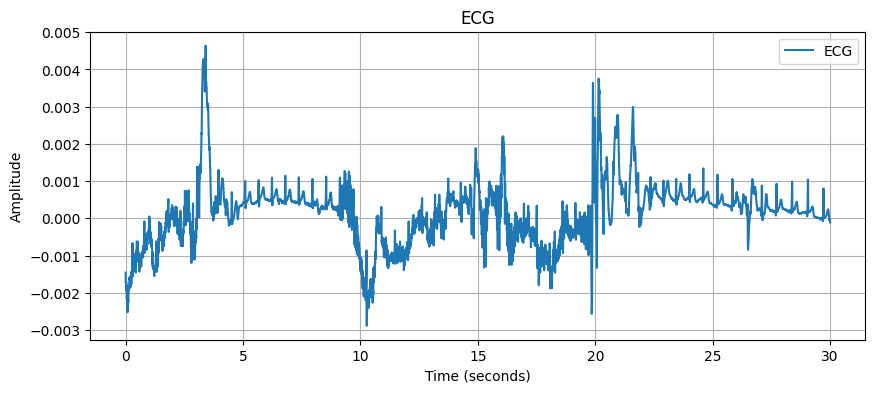

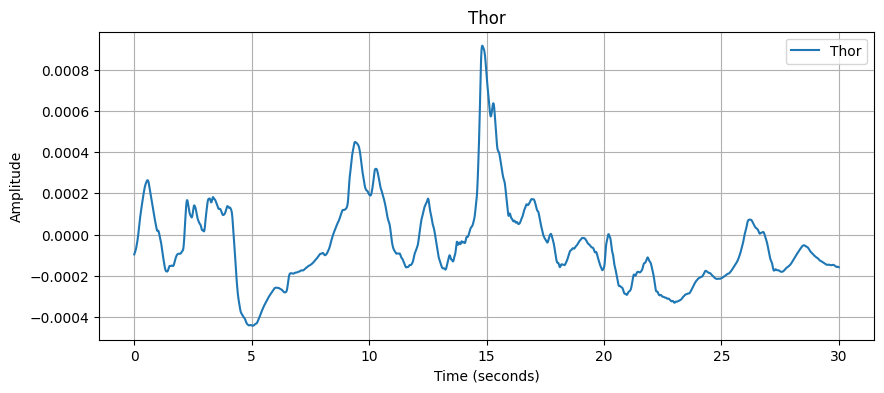

In [9]:
import mne
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt

class PSGDataProcessor:
    def __init__(self, psg_file):
        """
        Initialize the PSGDataProcessor class with the path to the PSG data file.
        
        Args:
        psg_file (str): Path to the PSG file.
        """
        # Load the raw data from EDF file
        self.data = mne.io.read_raw_edf(psg_file, preload=True)
        self.raw_data = self.data.get_data()
        self.sampling_rate = self.data.info['sfreq']
        
        # Adjusting for potential changes in the 'meas_date' type
        if isinstance(self.data.info['meas_date'], tuple):
            # If 'meas_date' is a tuple, convert to datetime object
            meas_date = datetime.fromtimestamp(self.data.info['meas_date'][0])
        else:
            # If 'meas_date' is already a datetime object
            meas_date = self.data.info['meas_date']
        
        self.start_datetime = meas_date.replace(tzinfo=None) # Make timestamp2 offset-naive by removing the timezone information

    def extract_segment_by_timestamp(self, start_datetime, end_datetime, data_types):
        """
        Extract specific types of data within a specified time range defined by timestamps.
        
        Args:
        start_datetime (datetime): Start datetime object.
        end_datetime (datetime): End datetime object.
        data_types (list): List of data types to extract, e.g., ['ECG', 'EEG'].
        
        Returns:
        dict: Dictionary of extracted data arrays keyed by type.
        """
        # Calculate start and end indices based on timestamps and sampling rate
        print(start_datetime, self.start_datetime)
        start_idx = int((start_datetime - self.start_datetime).total_seconds() * self.sampling_rate)
        end_idx = int((end_datetime - self.start_datetime).total_seconds() * self.sampling_rate)

        return self.extract_data_indices(start_idx, end_idx, data_types)

    def extract_data_indices(self, start_idx, end_idx, data_types):
        """
        Extract specific types of data within a specified index range.
        
        Args:
        start_idx (int): Start index.
        end_idx (int): End index.
        data_types (list): List of data types to extract, e.g., ['ECG', 'EEG'].
        
        Returns:
        dict: Dictionary of extracted data arrays keyed by type.
        """
        extracted_data = {}
        
        for data_type in data_types:
            data_array = np.array(self.data[data_type][0][0])
            extracted_data[data_type] = data_array[start_idx:end_idx]
        
        return extracted_data
    
    
    def plot_data(self, data, data_type, sampling_rate):
        """
        Plot the ECG data using Matplotlib.
        
        Args:
        ecg_data (numpy.ndarray): The ECG data to plot.
        sampling_rate (int): The sampling rate of the data.
        """
        # Create time axis in seconds
        time_axis = np.linspace(0, len(data) / sampling_rate, len(data))

        plt.figure(figsize=(10, 4))
        plt.plot(time_axis, data, label=data_type)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(data_type)
        plt.legend()
        plt.grid(True)
        plt.show()
        
# Example usage:
psg_file_path = "../../PSG_Data/sub2/sub2_yuanshishuju.edf"
processor = PSGDataProcessor(psg_file_path)

# Define the start and end datetime for the data segment you want to extract
start_datetime = datetime(2024, 1, 11, 14, 29, 53)
end_datetime = datetime(2024, 1, 11, 14, 30, 23)

# Extract ECG and EEG data between the specified timestamps
data_types = ['ECG', 'Thor']
extracted_data = processor.extract_segment_by_timestamp(start_datetime, end_datetime, data_types)
processor.plot_data(extracted_data['ECG'],'ECG', processor.sampling_rate)
processor.plot_data(extracted_data['Thor'],'Thor', processor.sampling_rate)